In [2]:
# Standard Imports
import numpy as np
from time import time
from matplotlib import pyplot as plt

# SHAPER
from pyshaper.CommonObservables import buildCommmonObservables
from pyshaper.Observables import Observable
from pyshaper.Shaper import Shaper

# SPECTER
from spectral_emd import compute_spectral_representation, cumulative_spectral_function
from spectral_emd import ds2


# Utils
from pyshaper.utils.data_utils import load_cmsopendata
from pyshaper.utils.plot_utils import plot_event




# Necessary GPU nonsense
import torch 

if torch.cuda.is_available():  
    dev = "cuda:0" 
    print("Using GPU!")
else:  
    dev = "cpu"  
    print("Using CPU!")
device = torch.device(dev) 

Using CPU!


[0.  0.5 0.5]
[0.00558659 0.4972067  0.4972067 ]
[0.01117318 0.49441341 0.49441341]
[0.01675978 0.49162011 0.49162011]
[0.02234637 0.48882682 0.48882682]
[0.02793296 0.48603352 0.48603352]
[0.03351955 0.48324022 0.48324022]
[0.03910615 0.48044693 0.48044693]
[0.04469274 0.47765363 0.47765363]
[0.05027933 0.47486034 0.47486034]
[0.05586592 0.47206704 0.47206704]
[0.06145251 0.46927374 0.46927374]
[0.06703911 0.46648045 0.46648045]
[0.0726257  0.46368715 0.46368715]
[0.07821229 0.46089385 0.46089385]
[0.08379888 0.45810056 0.45810056]
[0.08938547 0.45530726 0.45530726]
[0.09497207 0.45251397 0.45251397]
[0.10055866 0.44972067 0.44972067]
[0.10614525 0.44692737 0.44692737]
[0.11173184 0.44413408 0.44413408]
[0.11731844 0.44134078 0.44134078]
[0.12290503 0.43854749 0.43854749]
[0.12849162 0.43575419 0.43575419]
[0.13407821 0.43296089 0.43296089]
[0.1396648 0.4301676 0.4301676]
[0.1452514 0.4273743 0.4273743]
[0.15083799 0.42458101 0.42458101]
[0.15642458 0.42178771 0.42178771]
[0.16201117 

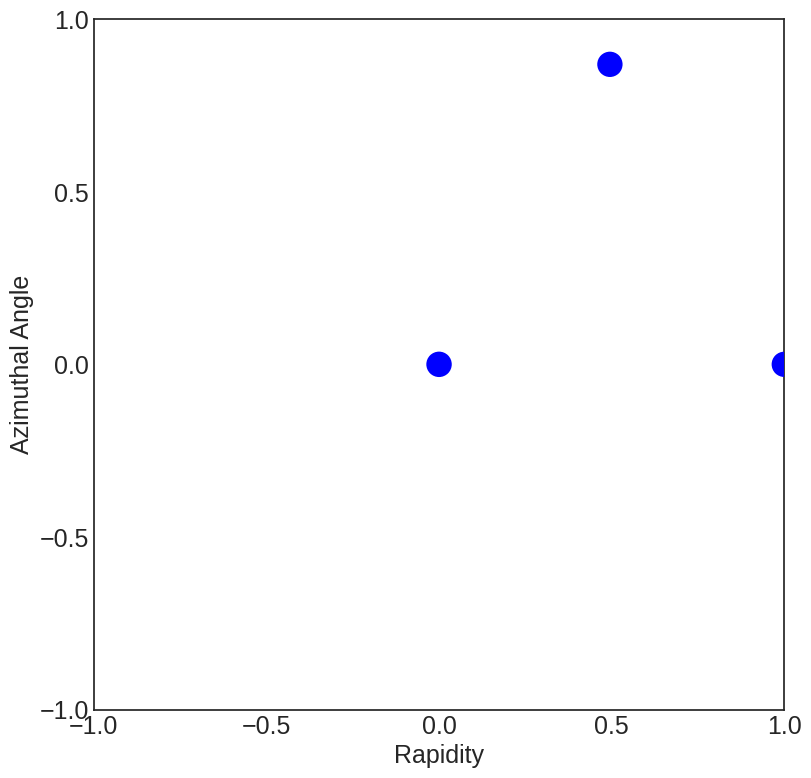

<Axes: xlabel='Rapidity', ylabel='Azimuthal Angle'>

In [42]:
# Build 3 particle events
R = 1.0
N = 180
angles = np.linspace(0, np.pi, N)
energies = np.linspace(0, 1, N)

events = []
for i in range(N):
    temp = []
    for j in range(N):

        e = energies[j]
        zs = np.array([e, (1-e)/2, (1-e)/2])
        points = np.array([
                            (0.0, 0.0),
                            (R, 0.0),
                            (R*np.cos(angles[i]), R*np.sin(angles[i]))
                ])
        temp.append((points, zs))
    events.append(temp)

triangle_event = events[60][60]
plot_event(triangle_event[0], triangle_event[1], R, color = "blue")




In [47]:
# EMDs

commonObservables, pointers = buildCommmonObservables(N = 3, beta = 2, R = R, device = device)
_2subjettiness = commonObservables["2-Subjettiness"]


# Collect our observables in one dictionary
observables = {}
observables["2-Subjettiness"] = _2subjettiness

# Initialize SHAPER
shaper = Shaper(observables, device)
shaper.to(device)


EMDs = []
for (i,batch) in enumerate(events):

    temp = []
    print("BATCH: %d" % i)


    dataset_emds, dataset_params = shaper.calculate(batch, epochs = 500, verbose=True, lr = 0.01, N = 50, scaling = 0.9, epsilon = 0.001, early_stopping= 25)
    for j in range(N):
        e = dataset_params["2-Subjettiness"][j]["EMD"]
        temp.append(e)

    EMDs.append(temp)

EMDs = np.array(EMDs)

BATCH: 0
Observable: 2-Subjettiness Epoch 0 Mean Loss = -2.3996052058963516e-12 Elapsed time = 0.039s Percentage done = 0.000 
Observable: 2-Subjettiness Epoch 1 Mean Loss = 7.75869963951613e-05 Elapsed time = 0.139s Percentage done = 0.000 
Observable: 2-Subjettiness Epoch 2 Mean Loss = 0.0005023421410644207 Elapsed time = 0.223s Percentage done = 0.000 
Observable: 2-Subjettiness Epoch 3 Mean Loss = 5.0282949652884986e-05 Elapsed time = 0.290s Percentage done = 0.000 
Observable: 2-Subjettiness Epoch 4 Mean Loss = 0.00024293139803275053 Elapsed time = 0.334s Percentage done = 0.000 
Observable: 2-Subjettiness Epoch 5 Mean Loss = 0.0003397918202810817 Elapsed time = 0.391s Percentage done = 0.000 
Observable: 2-Subjettiness Epoch 6 Mean Loss = 0.0001402309499907359 Elapsed time = 0.424s Percentage done = 0.000 
Observable: 2-Subjettiness Epoch 7 Mean Loss = 1.5900078415143072e-05 Elapsed time = 0.474s Percentage done = 0.000 
Observable: 2-Subjettiness Epoch 8 Mean Loss = 9.3791119515

/tmp/ipykernel_4250/3920928567.py:5: RuntimeWarning: invalid value encountered in sqrt
  plt.contourf(angles, energies, np.log(np.sqrt(EMDs.T) * 2), np.linspace(-5, 1, 25), cmap = "Reds", extend = "both")
/tmp/ipykernel_4250/3920928567.py:5: RuntimeWarning: divide by zero encountered in log
  plt.contourf(angles, energies, np.log(np.sqrt(EMDs.T) * 2), np.linspace(-5, 1, 25), cmap = "Reds", extend = "both")


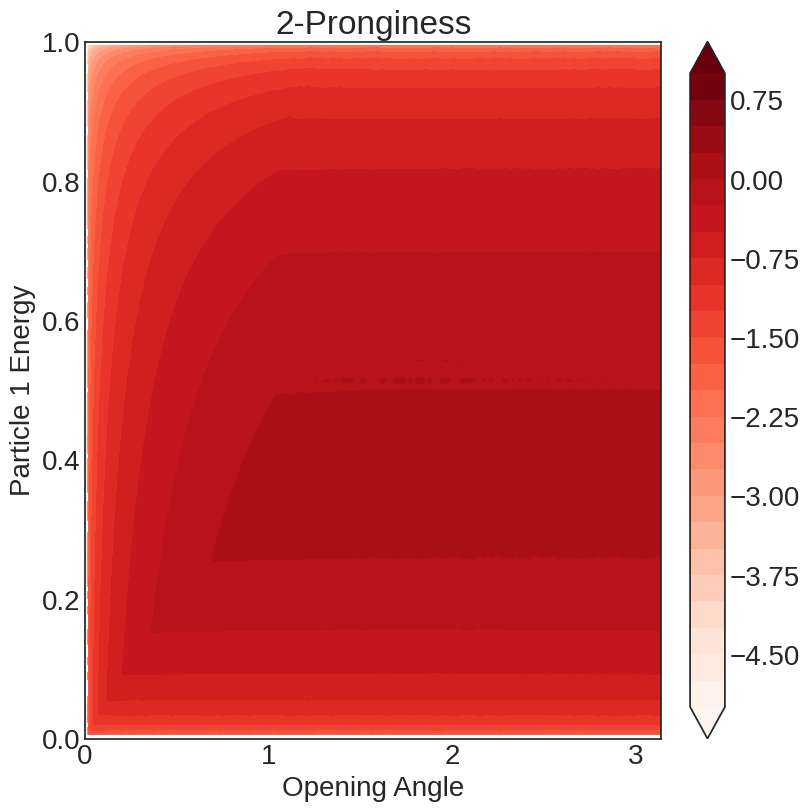

In [61]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8)) 


plt.contourf(angles, energies, np.log(np.sqrt(EMDs.T) * 2), np.linspace(-5, 1, 25), cmap = "Reds", extend = "both")
plt.xlabel("Opening Angle")
plt.ylabel("Particle 1 Energy")
plt.colorbar()

plt.title("2-Pronginess")
plt.clim(-5, 1)
# plt.clabel("log$_{10}EMD$")

In [32]:
# sEMDs
from tqdm import tqdm

sEMDs = []


for angle in tqdm(range(N)):


    bee = []

    for energy in range(N):

        es = np.linspace(0,0.5, 100)
        omegas = np.array((1,))
        Es, Omegas = np.meshgrid(es, omegas)
        temp = np.zeros_like(Es)
    

        for (i, e) in enumerate(es):
            for (j, omega) in enumerate(omegas):

                s = compute_spectral_representation(events[angle][energy], type = "jet")
                s2 = np.array((   (0, 1 - e), (omega, e),     ))
                d = ds2(s, s2)
                temp[j,i] = d

        bee.append(np.amin(temp))
    sEMDs.append(bee)

sEMDs = np.array(sEMDs)

100%|██████████| 180/180 [03:01<00:00,  1.01s/it]


/tmp/ipykernel_4250/1597015275.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.contourf(angles, energies, np.log10(sEMDs.T), cmap = "Blues", levels = 25)


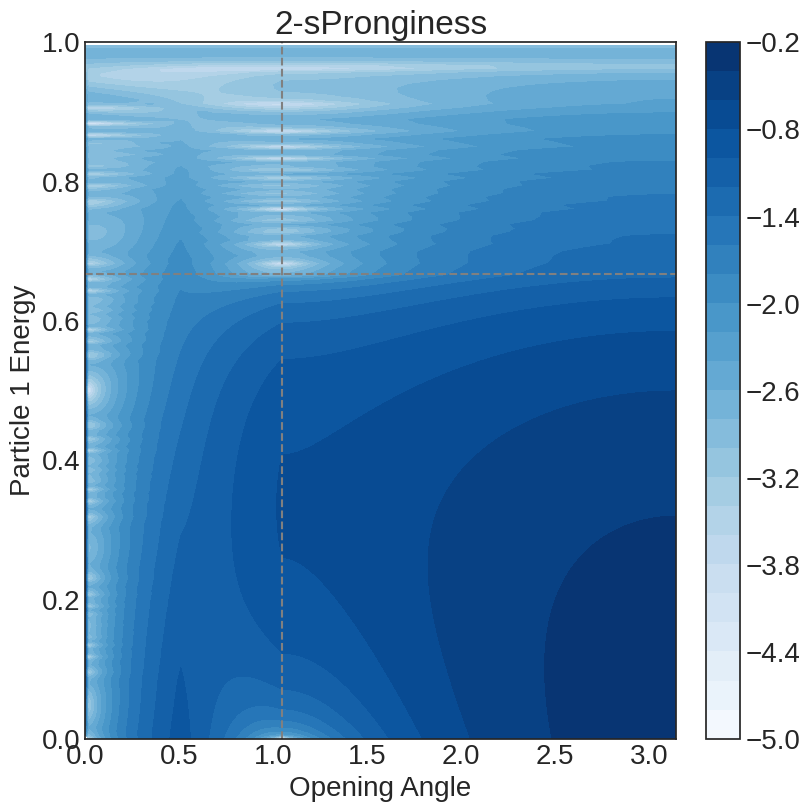

In [54]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8)) 


plt.contourf(angles, energies, np.log10(sEMDs.T), cmap = "Blues", levels = 25)
plt.xlabel("Opening Angle")
plt.ylabel("Particle 1 Energy")
plt.axvline(np.pi/3, ls = "--", color = "grey")
plt.axhline(2/3, ls = "--", color = "grey")

plt.title("2-sPronginess")
plt.colorbar()
# plt.clabel("log$_{10}d^2$")

(180,) (180,)


Text(0, 0.5, 'Observable')

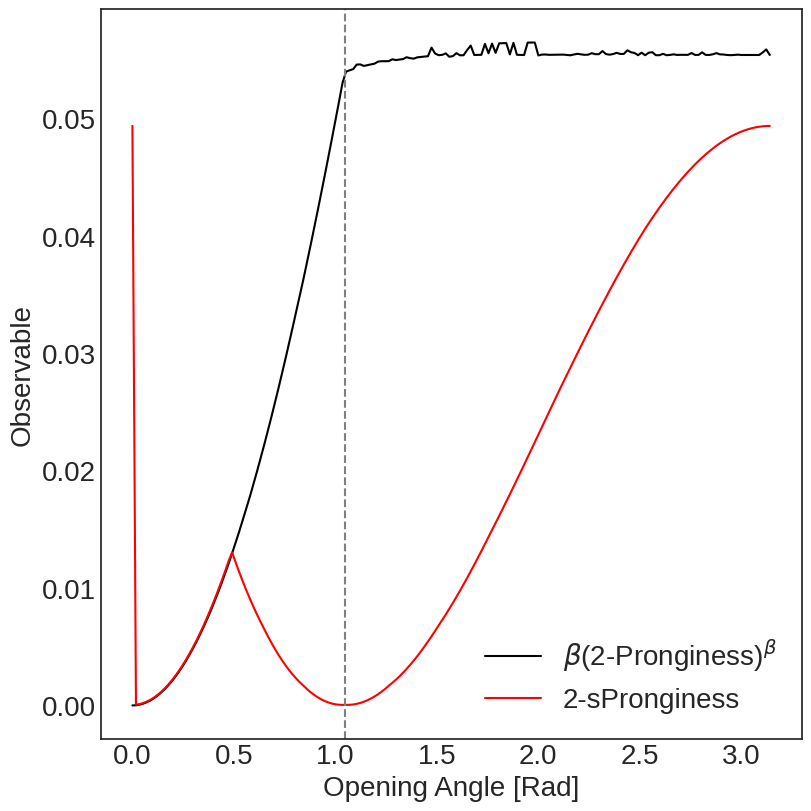

In [53]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))  

print(angles.shape, np.array(EMDs).shape)

plt.plot(angles, 2 * np.square(np.array(EMDs)), color = "black", label = r"$\beta$(2-Pronginess)$^\beta$")
plt.plot(angles, np.array(sEMDs), color = "red", label = "2-sPronginess")
plt.axvline(np.pi / 3, color = "grey", ls = "--")
plt.legend(frameon = False)

plt.xlabel("Opening Angle [Rad]")
plt.ylabel("Observable")

(99, 100)


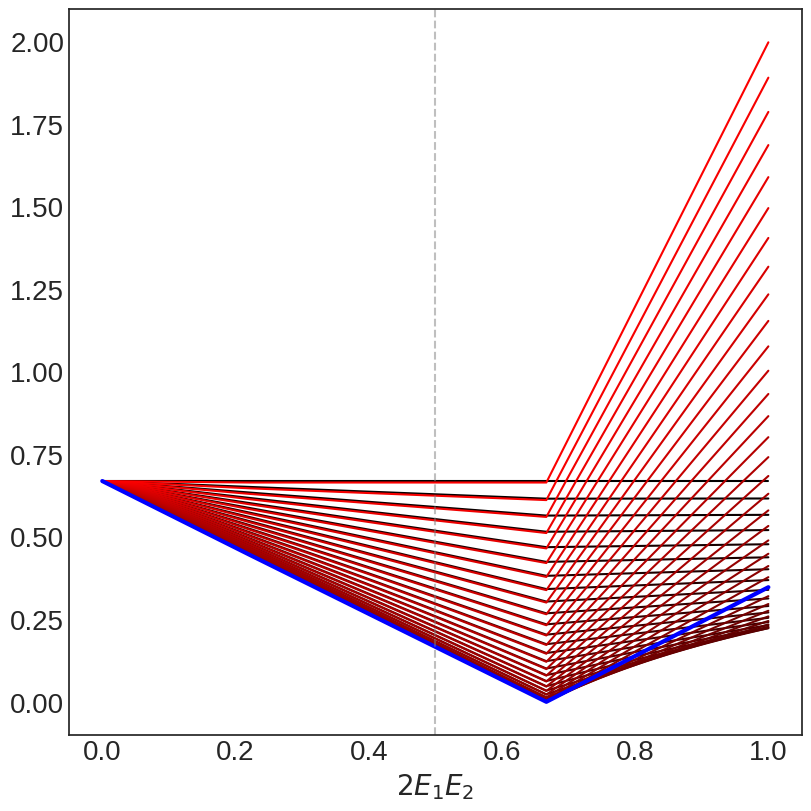

In [31]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))  

es = np.linspace(0,1, 100)
omegas = np.linspace(0,2, 99)
Es, Omegas = np.meshgrid(es, omegas)
temp = np.zeros_like(Es)

print(temp.shape)

for (i, e) in enumerate(es):
    for (j, omega) in enumerate(omegas):

        s = compute_spectral_representation(events[60][60], type = "jet")
        s2 = np.array((   (0, 1 - e), (omega, e),     ))
        d = ds2(s, s2)
        temp[j,i] = d


for (i, omega) in enumerate(omegas):
    if i % 2 == 0:
        plt.plot(es, temp[i,:], color = (i / len(omegas),0,0))

plt.plot(es, temp[50,:], color = (0,0,1), lw = 3)
plt.xlabel("$2E_1E_2$")
plt.axvline(0.5, color = "grey", alpha = 0.5, ls = "--")
